In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit

from functools import partial
import gwjax
import gwjax.imrphenom

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma, get_cutoff_indices
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform

dynfac = 1.0e23

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Define the conditiion data function
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template):
    workspace = jnp.zeros(sampling_rate*signal_duration, dtype=complex)
    template_fft = jnp.fft.fft(template) #WHY did I change this from a rfft to fft?
    result_fft = fcore * jnp.conj(template_fft)
    workspace = workspace.at[kmin:kmax].set(result_fft)#can't change array in Jax
    result = jnp.fft.ifft(workspace)   
    return result

# Define the waveform template function
def waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0, 'spin2': 0,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

def snr(invpsd, matched_output, template):
    #Compute sigma
    sigma_squared = jnp.sum(template*jnp.conj(template)*invpsd)

    # Compute the SNR
    snr = matched_output / sigma_squared**0.5
    
    snr_max = len(snr) - 2
    snr_min = 2+4
    snr = snr[snr_min:snr_max]
    peak = jnp.argmin(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return snrp

# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2 = params
    template, _ = my_waveform_template(m1, m2)
    matched_output = my_matched_filter(template)
    snr_peak = my_snr(matched_output, template)
    return -snr_peak

# Perform gradient descent
def gradient_descent(initial_m1, initial_m2, learning_rate, num_iterations, my_waveform_template, my_matched_filter, my_snr):
 
    # Initialize the parameters
    m1, m2 = initial_m1, initial_m2

    # Define the gradient of the objective function
    objective_grad = jit(grad(objective))

    for i in range(num_iterations):
        # Compute the gradient
        grad_m1, grad_m2 = objective_grad((m1, m2))

        # Update the parameters
        m1 -= learning_rate * grad_m1
        m2 -= learning_rate * grad_m2
        mass1_list.append(float(m1))
        mass2_list.append(float(m2))
        snr_list.append(float(objective(params=(m1, m2))))
        
    return m1, m2

In [5]:
sampling_rate = 2048  # Sampling rate in Hz
signal_duration = 8  # Duration of the signal in seconds 4 or 8

# Get the data and estimate the PSDs
merger = Merger("GW150914")
data = condition(merger.strain('H1'), sampling_rate)

invpsd = estimate_psd(data, data.delta_f)**(-1) #WHY NOT 1/signal_duration which is the example given in GWjax
#idx = int(sampling_rate * (merger.time - data.start_time))
#data[idx-4*sampling_rate:idx+4*sampling_rate]
fcore = data.to_frequencyseries()*invpsd #this is what goes to multiply with template^*

#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration

#Determine the low freq and high frequency cut off
kmin, kmax = 15*signal_duration, 900*signal_duration
#kmin, kmax = get_cutoff_indices(flow=15, fhigh=900, df=data.delta_f, N=signal_duration) # WHY DID you avoid using this?
#And I don't understand what the difference is between freq and kmin

#Make everything the same length
fcore = jnp.asarray(fcore[kmin:kmax])
freqs = freqs[kmin:kmax]
invpsd = jnp.asarray(invpsd[kmin:kmax]) # can't take fft because it needs to start at 0 to nyquist 

#Get the stage ready for the template
my_waveform_template = partial(waveform_template, freqs)
my_matched_filter = partial(matched_filter, signal_duration, sampling_rate, kmin, kmax, fcore)
my_snr = partial(snr, invpsd)

# Set the initial mass parameters for the template
initial_m1 = 39.0 #from the Optuna section of GWtuna
initial_m2 = 34.0 #from t he Optuna section of GWtuna

# Set the learning rate and number of iterations for gradient descent
learning_rate = 0.001
num_iterations = 100

mass1_list = []
mass2_list = []
snr_list = []

# Perform gradient descent to find the lowest SNR
optimized_m1, optimized_m2 = gradient_descent(initial_m1, initial_m2, learning_rate, num_iterations, my_waveform_template, my_matched_filter, my_snr)

print("Optimized Mass and Spin Parameters: m1 =", optimized_m1, "m2 =", optimized_m2)

Optimized Mass and Spin Parameters: m1 = 38.99708398240317 m2 = 33.996172147192155


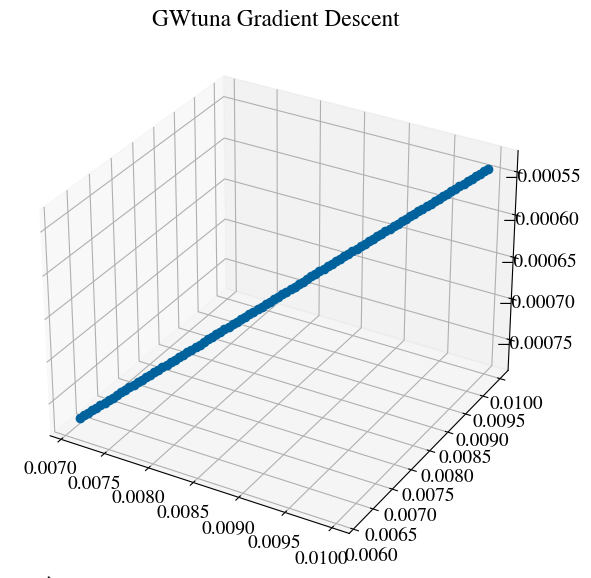

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.autolayout"] = True

from mpl_toolkits.mplot3d import Axes3D

# Setting up Data Set for Animation
dataSet = np.array([mass1_list, mass2_list, snr_list])  # Combining our position coordinates
numDataPoints = len(mass1_list)

def animate_func(num):
    ax.clear()  # Clears the figure to update the line, point,   
                # title, and axes
    # Updating Trajectory Line (num+1 due to Python indexing)
    ax.plot3D(dataSet[0, :num+1], dataSet[1, :num+1], 
              dataSet[2, :num+1], c='#00629d',  marker='o', linestyle='None')
    # Updating Point Location 
    ax.scatter(dataSet[0, num], dataSet[1, num], dataSet[2, num], 
               c='#00629d', marker='o')
    # Adding Constant Origin
    #ax.plot3D(dataSet[0, 0], dataSet[1, 0], dataSet[2, 0],     
    #           c='black', marker='o')
    # Setting Axes Limits
    #ax.set_xlim3d([0, 100])
    #ax.set_ylim3d([0, 100])
    #ax.set_zlim3d([0, 12])

    # Adding Figure Labels
    ax.set_title('GWtuna Gradient Descent')
    #ax.set_xlabel('Mass 1')
    #ax.set_ylabel('Mass 2')
    #ax.set_zlabel('SNR')

# Plotting the Animation
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = plt.axes(projection='3d')
line_ani = animation.FuncAnimation(fig, animate_func, interval=100,   
                                   frames=numDataPoints)

# save the animation as mp4 video file 
line_ani.save('GDJax.gif', writer='imagemagick') 
plt.show()